# Stastic Arbitrage for Trading Analysis

<a href="https://www.kaggle.com/code/addarm/efficient-frontier-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

![TODO]()

## Prepare your Environment

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance

You'll need access to [analysis_utils](./analysis_utils.py) library for common functions.

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_prices_ts_df, plot_strategy, load_ticker_ts_df

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


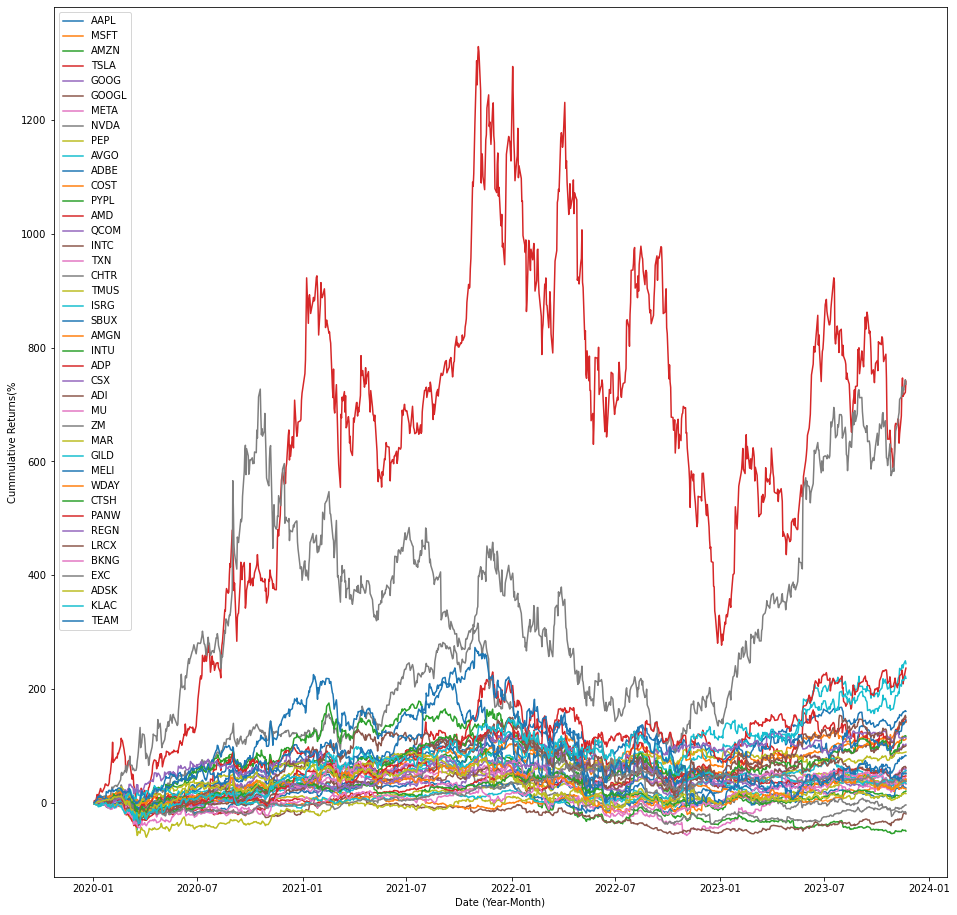

In [5]:
START_DATE = "2020-01-01"
END_DATE = "2023-11-22"

tickers = [
    "AAPL",
    "MSFT",
    "AMZN",
    "TSLA",
    "GOOG",
    "GOOGL",
    "META",
    "NVDA",
    "PEP",
    "AVGO",
    "ADBE",
    "COST",
    "PYPL",
    "AMD",
    "QCOM",
    "INTC",
    "TXN",
    "CHTR",
    "TMUS",
    "ISRG",
    "SBUX",
    "AMGN",
    "INTU",
    "ADP",
    "CSX",
    "ADI",
    "MU",
    "ZM",
    "MAR",
    "GILD",
    "MELI",
    "WDAY",
    "CTSH",
    "PANW",
    "REGN",
    "LRCX",
    "BKNG",
    "EXC",
    "ADSK",
    "KLAC",
    "TEAM",
]
tickers_df = load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
graph_df = tickers_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

# 1+ to allow the cumulative product of returns over time, and -1 to remove it at the end.
graph_df = (1 + graph_df).cumprod() - 1

plt.figure(figsize=(16, 16))
for ticker in graph_df.columns:
    plt.plot(graph_df.index, graph_df[ticker] * 100.0, label=ticker)

plt.xlabel("Date (Year-Month)")
plt.ylabel("Cummulative Returns(%")
plt.legend()
plt.show()

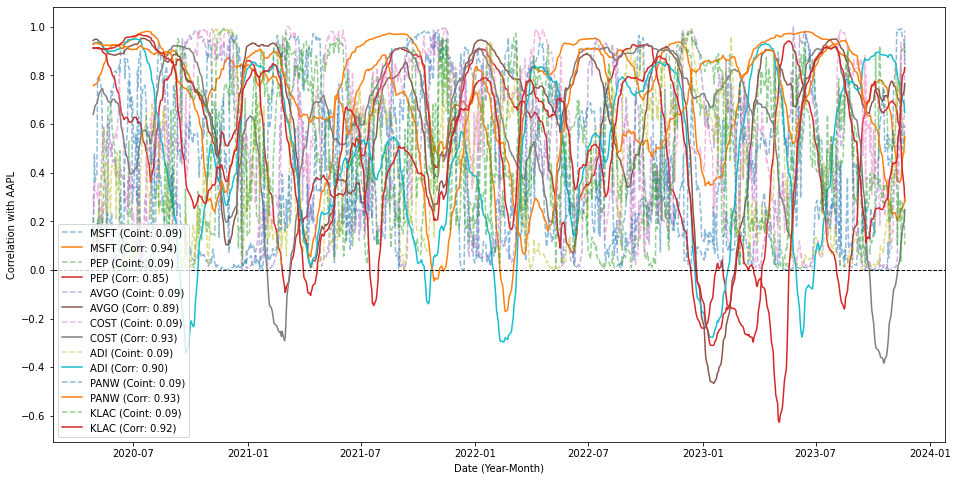

In [10]:
import statsmodels
from statsmodels.tsa.stattools import coint

TARGET = "AAPL"
MA_WINDOW = 20
ARB_WINDOW = 80

plt.figure(figsize=(16, 8))

corr_ticks = []

for ticker in tickers:
    if ticker == TARGET:
        continue
    correlation = graph_df[ticker].corr(graph_df[TARGET])
    if abs(correlation) < 0.85:
        continue

    p_values = [
        coint(
            graph_df[ticker].iloc[i - ARB_WINDOW + 1 : i + 1],
            graph_df[TARGET].iloc[i - ARB_WINDOW + 1 : i + 1],
        )[1]
        for i in range(ARB_WINDOW - 1, len(graph_df))
    ]
    plt.plot(
        graph_df.index[ARB_WINDOW - 1 :],
        p_values,
        label=f"{ticker} (Coint: {p:.2f})",
        linestyle="--",
        alpha=0.5,
    )
    corr_ts = graph_df[ticker].rolling(ARB_WINDOW).corr(graph_df[TARGET])
    plt.plot(graph_df.index, corr_ts, label=f"{ticker} (Corr: {correlation:.2f})")
    corr_ticks.append(ticker)

plt.axhline(
    0, color="black", linestyle="--", linewidth=1
)  # Add a horizontal line at correlation 0
plt.xlabel("Date (Year-Month)")
plt.ylabel("Correlation with AAPL")
plt.legend()
plt.show()

The magnitude of the covariance may be more aligned with the desired/appropriate portfolio weights than correlation. Correlation ranges from -1 to 1 by definition, while covariance is unbounded.

Good question! Let me explain the covariance calculation here in a bit more detail:

The formula for covariance between two variables X and Y is:

Cov(X,Y) = Σ((X - μX) * (Y - μY)) / N

Where:

μX is the mean of X  
μY is the mean of Y
N is the number of observations

Applying this to our ice cream and drowning example:

- Mean ice cream sales (μX) = $200  
- Mean drowning deaths (μY) = 20
- N (number of months) = 5

Plugging this into our sum of products and dividing by N:

Cov(ice cream sales, drowning deaths) = Σ(X-200)(Y-20) / 5 
                                        = 50

So here, the covariance value of 50 represents the sum of products of the deviation from the mean for each variable over the sample. 

While 50 doesn't have an inherent exact interpretation, the sign positive sign indicates the variables move in the same direction, while the magnitude represents the level of co-movement. 

A higher positive covariance means that when one variable increases, the other tends to increase meaningfully too. So the magnitude measures the tendency of the variables to vary together.

Let me know if this helps explain what that covariance value of 50 represents!

delta positive => signal says TRADING_INSTRUMENT price should have moved up more than what it did
delta negative => signal says TRADING_INSTRUMENT price should have moved down more than what it did.

In [7]:
BUY_SIG = 0.01
SELL_SIG = -0.01

signals = []

arb_df = tickers_df.copy()
arb_df[f"ema_{TARGET}"] = arb_df[TARGET].ewm(MA_WINDOW, min_periods=MA_WINDOW).mean()
arb_df[f"ema_d_{TARGET}"] = arb_df[TARGET] - arb_df[f"ema_{TARGET}"]
arb_df[f"ema_d_{TARGET}"].fillna(0, inplace=True)

for ticker in tickers:
    if ticker == TARGET:
        continue

    arb_df[f"ema_{ticker}"] = (
        arb_df[ticker].ewm(MA_WINDOW, min_periods=MA_WINDOW).mean()
    )

    arb_df[f"ema_d_{ticker}"] = arb_df[ticker] - arb_df[f"ema_{ticker}"]
    arb_df[f"ema_d_{ticker}"].fillna(0, inplace=True)

    arb_df[f"{ticker}_corr_{TARGET}"] = (
        arb_df[f"ema_d_{TARGET}"].rolling(ARB_WINDOW).corr(arb_df[f"ema_d_{ticker}"])
    )

    arb_df[f"{ticker}_covr_{TARGET}"] = (
        arb_df[[f"ema_d_{TARGET}", f"ema_d_{ticker}"]]
        .rolling(ARB_WINDOW)
        .cov(min_periods=ARB_WINDOW, numeric_only=True)
        .groupby(level=0, axis=0, dropna=True)  # Cov returns pairwise!
        .apply(lambda x: x.iloc[0, 0] / x.iloc[0, 1])
    )
    arb_df[f"{ticker}_pmv_{TARGET}"] = (
        arb_df[f"ema_d_{ticker}"] * arb_df[f"{ticker}_covr_{TARGET}"]
    )

    arb_df[f"{ticker}_dmv_{TARGET}"] = (
        arb_df[f"{ticker}_pmv_{TARGET}"] - arb_df[f"ema_d_{TARGET}"]
    )

arb_df[
    ["AAPL", "AMZN", "ema_d_AAPL", "AMZN_covr_AAPL", "AMZN_pmv_AAPL", "AMZN_dmv_AAPL"]
]

TypeError: cov() got an unexpected keyword argument 'min_periods'

In [ ]:
import matplotlib.pyplot as plt

TARGET = "AAPL"
LEADER = "AMZN"
MA_WINDOW = 20
ARB_WINDOW = 80
BUY_SIG = 1.0
SELL_SIG = -1.0

# Calculate percentage difference for price and EMA (1 + graph_df).cumprod() - 1
arb_df[f"{TARGET}_pct"] = (1 + arb_df[TARGET].pct_change().dropna()).cumprod() - 1
arb_df[f"{LEADER}_pct"] = (1 + arb_df[LEADER].pct_change().dropna()).cumprod() - 1
arb_df[f"ema_{TARGET}_pct"] = (
    1 + arb_df[f"ema_{TARGET}"].pct_change().dropna()
).cumprod() - 1
arb_df[f"ema_{LEADER}_pct"] = (
    1 + arb_df[f"ema_{LEADER}"].pct_change().dropna()
).cumprod() - 1

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
fig.suptitle(
    f"Percentage Price Change, EMAs, and DMV Signal for {TARGET} with {LEADER} as Leader"
)

# Plot Percentage Price Lines and EMAs
ax1.plot(
    arb_df.index,
    arb_df[f"{TARGET}_pct"] * 100,
    label=f"{TARGET} % Change",
    linestyle="-",
    color="b",
)
ax1.plot(
    arb_df.index,
    arb_df[f"ema_{TARGET}_pct"] * 100,
    label=f"EMA_{TARGET} % Change",
    linestyle="--",
    color="b",
)
ax1.plot(
    arb_df.index,
    arb_df[f"{LEADER}_pct"] * 100,
    label=f"{TARGET} % Change",
    linestyle="-",
    color="r",
)
ax1.plot(
    arb_df.index,
    arb_df[f"ema_{LEADER}_pct"] * 100,
    label=f"EMA_{TARGET} % Change",
    linestyle="--",
    color="r",
)
ax1.set_ylabel("Percentage Change")
ax1.legend()

# Plot DMV Signal
ax2.set_ylim(-60, 60)
ax2.plot(
    arb_df.index,
    arb_df[f"{LEADER}_dmv_{TARGET}"],
    label=f"EMA_d_{TARGET}",
    linestyle="--",
    color="black",
)
ax2.axhline(BUY_SIG, color="green", linestyle="--", label="Buy Signal")
ax2.axhline(SELL_SIG, color="red", linestyle="--", label="Sell Signal")
ax2.set_xlabel("Date")
ax2.set_ylabel("Percentage Change")
ax2.legend()

plt.show()

In [ ]:
weights = 0
for ticker in tickers:
    if ticker == TARGET:
        continue
    weights += abs(arb_df[f"{ticker}_corr_{TARGET}"])
weights.tail(1)

In [ ]:
delta_projected = 0
for ticker in tickers:
    if ticker == TARGET:
        continue
    delta_projected += (
        arb_df[f"{ticker}_corr_{TARGET}"] * arb_df[f"{ticker}_dmv_{TARGET}"]
    )
    arb_df[f"{ticker}_d_prj"] = delta_projected / weights

arb_df.tail(1)

In [ ]:
from itertools import cycle

cycol = cycle("bgrcmky")
correlation_data = pd.DataFrame()
for symbol in tickers:
    if symbol == TARGET:
        continue
    correlation_data = correlation_data.assign(
        label=pd.Series(
            arb_df[f"{ticker}_corr_{TARGET}"], index=tickers_df[TARGET].index
        )
    )
    ax = correlation_data["label"].plot(
        color=next(cycol), lw=2.0, label=f"{ticker}_corr_{TARGET}"
    )

for i in np.arange(-1, 1, 0.25):
    plt.axhline(y=i, lw=0.5, color="k")
plt.legend()
plt.show()

# Plot StatArb signal provided by each currency pair
delta_projected_actual_data = pd.DataFrame()
for symbol in tickers:
    if symbol == TARGET:
        continue
    delta_projected_actual_data = delta_projected_actual_data.assign(
        StatArbTradingSignal=pd.Series(
            arb_df[f"{ticker}_d_prj"],
            index=tickers_df[TARGET].index,
        )
    )
    ax = delta_projected_actual_data["StatArbTradingSignal"].plot(
        color=next(cycol), lw=1.0, label=f"{ticker}_d_prj"
    )

plt.legend()
plt.show()

# Conclusion

TODO

![TODO]()

## References

- https://www.nasdaq.com/solutions/nasdaq-100/companies
- 
## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.